In [1]:
import warnings 
import itertools

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
region_name_dicts = {5: 'Eastern U.S.', 17: 'West-Central Europe', 58: 'North East Asia'}
simulation_name_dicts = {'ref': 'Present', 'refshort': 'High-warming', 'pol3.7short': 'Low-warming'}

In [3]:
ref_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.SpeciesConc.april-august.nc4")
refshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.SpeciesConc.april-august.nc4")
polshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.SpeciesConc.april-august.nc4")

data_arrays_spec = [ref_ds_spec, refshort_ds_spec, polshort_ds_spec]

In [4]:
# Count total number of days between April and August
import pandas as pd
time_index = pd.to_datetime(ref_ds_spec.time.values)
april_aug_mask = (time_index.month >= 4) & (time_index.month <= 8)
total_days = april_aug_mask.sum()
print(f"Total days between April 1 and August 31: {total_days}")

Total days between April 1 and August 31: 2448


In [5]:
def get_regional_data(ds, my_variable, my_simulation, months, scale_factor):
    da = ds[my_variable]
    da = tools.mask_ocean_c48(da)
    da = da.sel(time=da.time.dt.month.isin(months))
    da = da.resample(time='1Y').mean() * scale_factor
    da = da.stack(new_dim=['sim', 'time'])
    da['name'] = simulation_name_dicts[my_simulation]

    #EUS: 
    region_num = 5
    da_EUS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EUS = da_EUS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EUS['region_name'] = region_name_dicts[region_num]

    #WCE: 
    region_num = 17
    da_WCE = tools.crop_regionmask_ar6_c48(da, region_num)
    da_WCE = da_WCE.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_WCE['region_name'] = region_name_dicts[region_num]

    #EAS: 
    region_num = 58
    da_EAS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EAS = da_EAS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EAS['region_name'] = region_name_dicts[region_num]

    da_all = xr.concat([da_EUS, da_WCE, da_EAS],dim='concat_dim')
    return da_all

In [6]:
def get_dataframe(my_variable, data_arrays, months, scale_factor):

    if my_variable == "SpeciesConc_HOx":
        ref_HO2 = get_regional_data(data_arrays[0], "SpeciesConc_HO2", "ref", months, scale_factor)
        ref_OH = get_regional_data(data_arrays[0], "SpeciesConc_OH", "ref", months, scale_factor)
        ref = (ref_HO2+ref_OH)

        refshort_HO2 = get_regional_data(data_arrays[1], "SpeciesConc_HO2", "refshort", months, scale_factor)
        refshort_OH = get_regional_data(data_arrays[1], "SpeciesConc_OH", "refshort", months, scale_factor)
        refshort = (refshort_HO2+refshort_OH)

        polshort_HO2 = get_regional_data(data_arrays[2], "SpeciesConc_HO2", "pol3.7short", months, scale_factor)
        polshort_OH = get_regional_data(data_arrays[2], "SpeciesConc_OH", "pol3.7short", months, scale_factor)
        polshort = (polshort_HO2+polshort_OH)

        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe(name="SpeciesConc_HOx")
    else:    
        ref = get_regional_data(data_arrays[0], my_variable, "ref", months, scale_factor)
        refshort = get_regional_data(data_arrays[1], my_variable, "refshort", months, scale_factor)
        polshort = get_regional_data(data_arrays[2], my_variable, "pol3.7short", months, scale_factor)
        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe()
    return df 

In [7]:
months = [4,5,6,7,8]
scale_factor = 1e6 # ppmv
SpeciesConc_H2O_df = get_dataframe("SpeciesConc_H2O", data_arrays_spec, months, scale_factor)

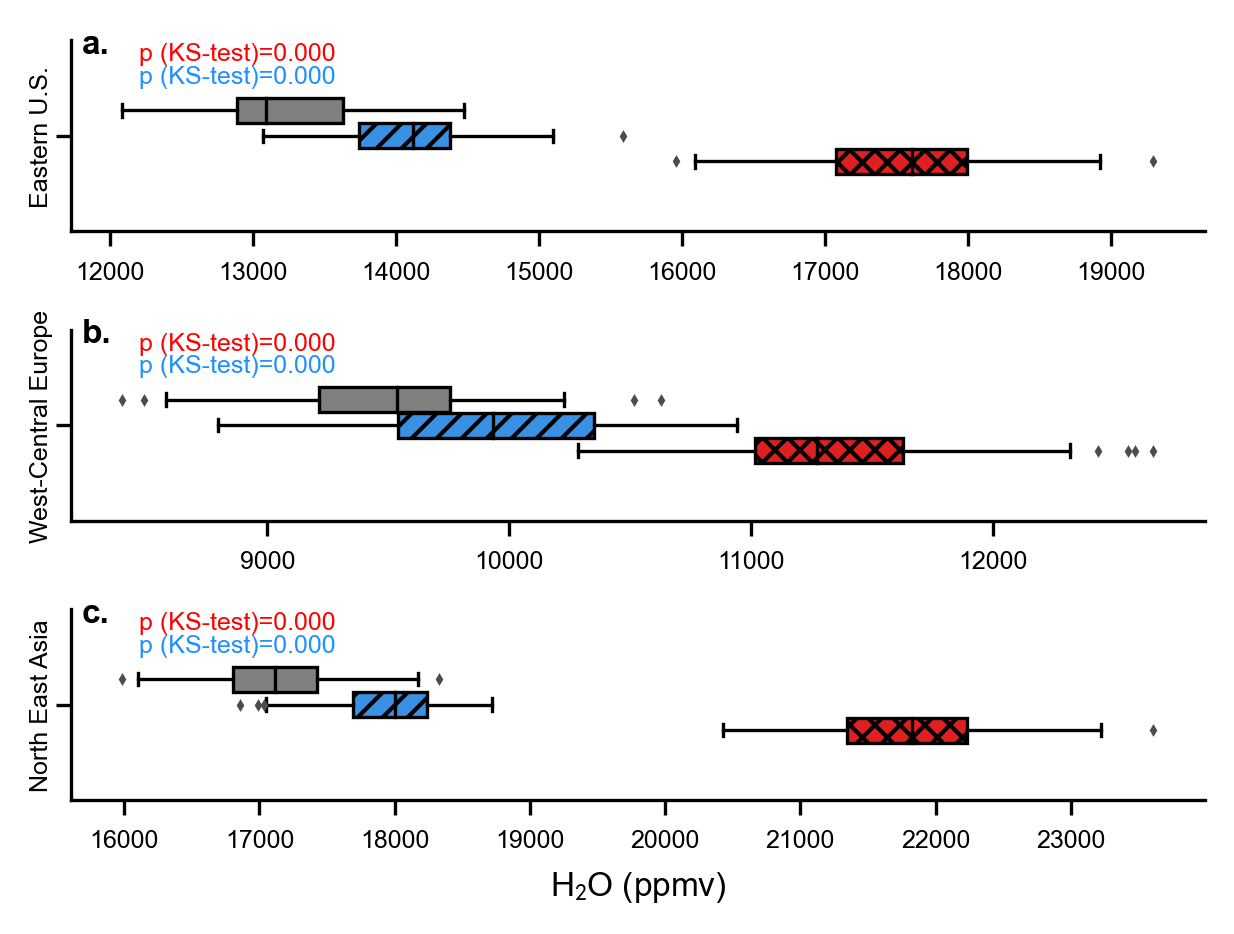

In [8]:

tools.set_matplotlib_font("Arial")
fig = plt.figure(figsize=(4, 3), dpi=300, constrained_layout=True)

# Create the outer GridSpec for 2 rows x 2 columns of subfigures
outer_gs = gridspec.GridSpec(1, 1, figure=fig, top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.50, wspace=0.5)

dfs = [SpeciesConc_H2O_df]
PROPS = {
    'boxprops': {'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k'}
}
my_variables = ['SpeciesConc_H2O']
xlabels = [
    r"H$_2$O (ppmv)",
]
colors = ["grey", "dodgerblue", "red"]
regions = ['Eastern U.S.', 'West-Central Europe', 'North East Asia']
titles = ["a.", "b.", "c."]

for outer_ind in range(1):
    
    row = outer_ind // 2
    col = outer_ind % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[row, col])
    
    df = dfs[outer_ind]
    variable = my_variables[outer_ind]
    xlabel = xlabels[outer_ind]

    # Loop over inner GridSpec rows to create each subplot
    for inner_ind in range(3):

        global_idx = outer_ind * 3 + inner_ind

        ax = fig.add_subplot(inner_gs[inner_ind, 0])
        region = regions[inner_ind]
        data = df[df.region_name == region]

        a = sns.boxplot(
            x=variable, y="region_name", ax=ax,
            hue="name", palette=colors, width=0.4, whis=1.2, linewidth=0.8, fliersize=0.8,
            data=data, **PROPS
        )

        hatches = ['////', '', 'xxxx', '////', '', 'xxxx']
        for i, bar in enumerate(a.patches):
            if i < len(hatches):
                bar.set_hatch(hatches[i])

        p_pd = data[data.name == 'Present'].dropna()
        f_pd = data[data.name == 'High-warming'].dropna()
        fp_pd = data[data.name == 'Low-warming'].dropna()

        _, f_pval_ks = stats.ks_2samp(p_pd[variable], f_pd[variable])
        _, fp_pval_ks = stats.ks_2samp(p_pd[variable], fp_pd[variable])

        formatted_f_pval_ks = format(f_pval_ks, ".3f")
        formatted_fp_pval_ks = format(fp_pval_ks, ".3f")

        ax.text(0.01, 1.06, titles[global_idx],
                ha='left', va='top', transform=ax.transAxes, color='black', fontsize=8, weight='bold')
        ax.text(0.06, 0.99, "p (KS-test)=" + formatted_f_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='red', fontsize=6)
        ax.text(0.06, 0.87, "p (KS-test)=" + formatted_fp_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='dodgerblue', fontsize=6)

        ax.set_ylabel(None)
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', va='center', fontsize=6)
        ax.legend([], [], frameon=False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=6)

        # Set xlabel only for the bottom subplot in each column
        if inner_ind == 2:
            ax.set_xlabel(xlabel, fontsize=8)
        else:
            ax.set_xlabel("")

###########################################
plt.savefig("FigS6_new.png")
